# Generate the time series of TN

In [6]:
import numpy as np

# Seed for reproducibility
np.random.seed(42)

def generate_TN_time_series(duration=40000, on_time=2000, off_time=5000, on_amp=1, off_amp=-1, perturbation=True):
    """
    Generate a TN time series with specified parameters and optional perturbations.

    Parameters:
    - duration: Total duration of the time series in years.
    - on_time, off_time: Duration of the on and off states in years.
    - on_amp, off_amp: Amplitudes for the on and off states.
    - perturbation: Whether to apply random perturbations to the amplitudes and durations.

    Returns:
    - A numpy array representing the TN time series.
    """
    time_series = []
    time = 0
    np.random.seed(42)

    while time < duration:
        # Apply random perturbations
        current_on_time = on_time + np.random.uniform(0, 1000) if perturbation else on_time
        current_off_time = off_time + np.random.uniform(0, 1000) if perturbation else off_time
        current_on_amp = on_amp + np.random.uniform(0, 0.3) if perturbation else on_amp
        current_off_amp = off_amp + np.random.uniform(0, 0.3) if perturbation else off_amp

        # Ensure the series does not exceed the specified duration
        if time + current_on_time <= duration:
            time_series.extend([current_on_amp] * int(current_on_time))
            time += current_on_time
        else:
            break

        if time + current_off_time <= duration:
            time_series.extend([current_off_amp] * int(current_off_time))
            time += current_off_time
        else:
            break

    return np.array(time_series)

# Generate the TN time series
tn_time_series = generate_TN_time_series()

# Display the first 100 data points to get a sense of the series
tn_time_series[:100]


array([1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959

# Plot the TN

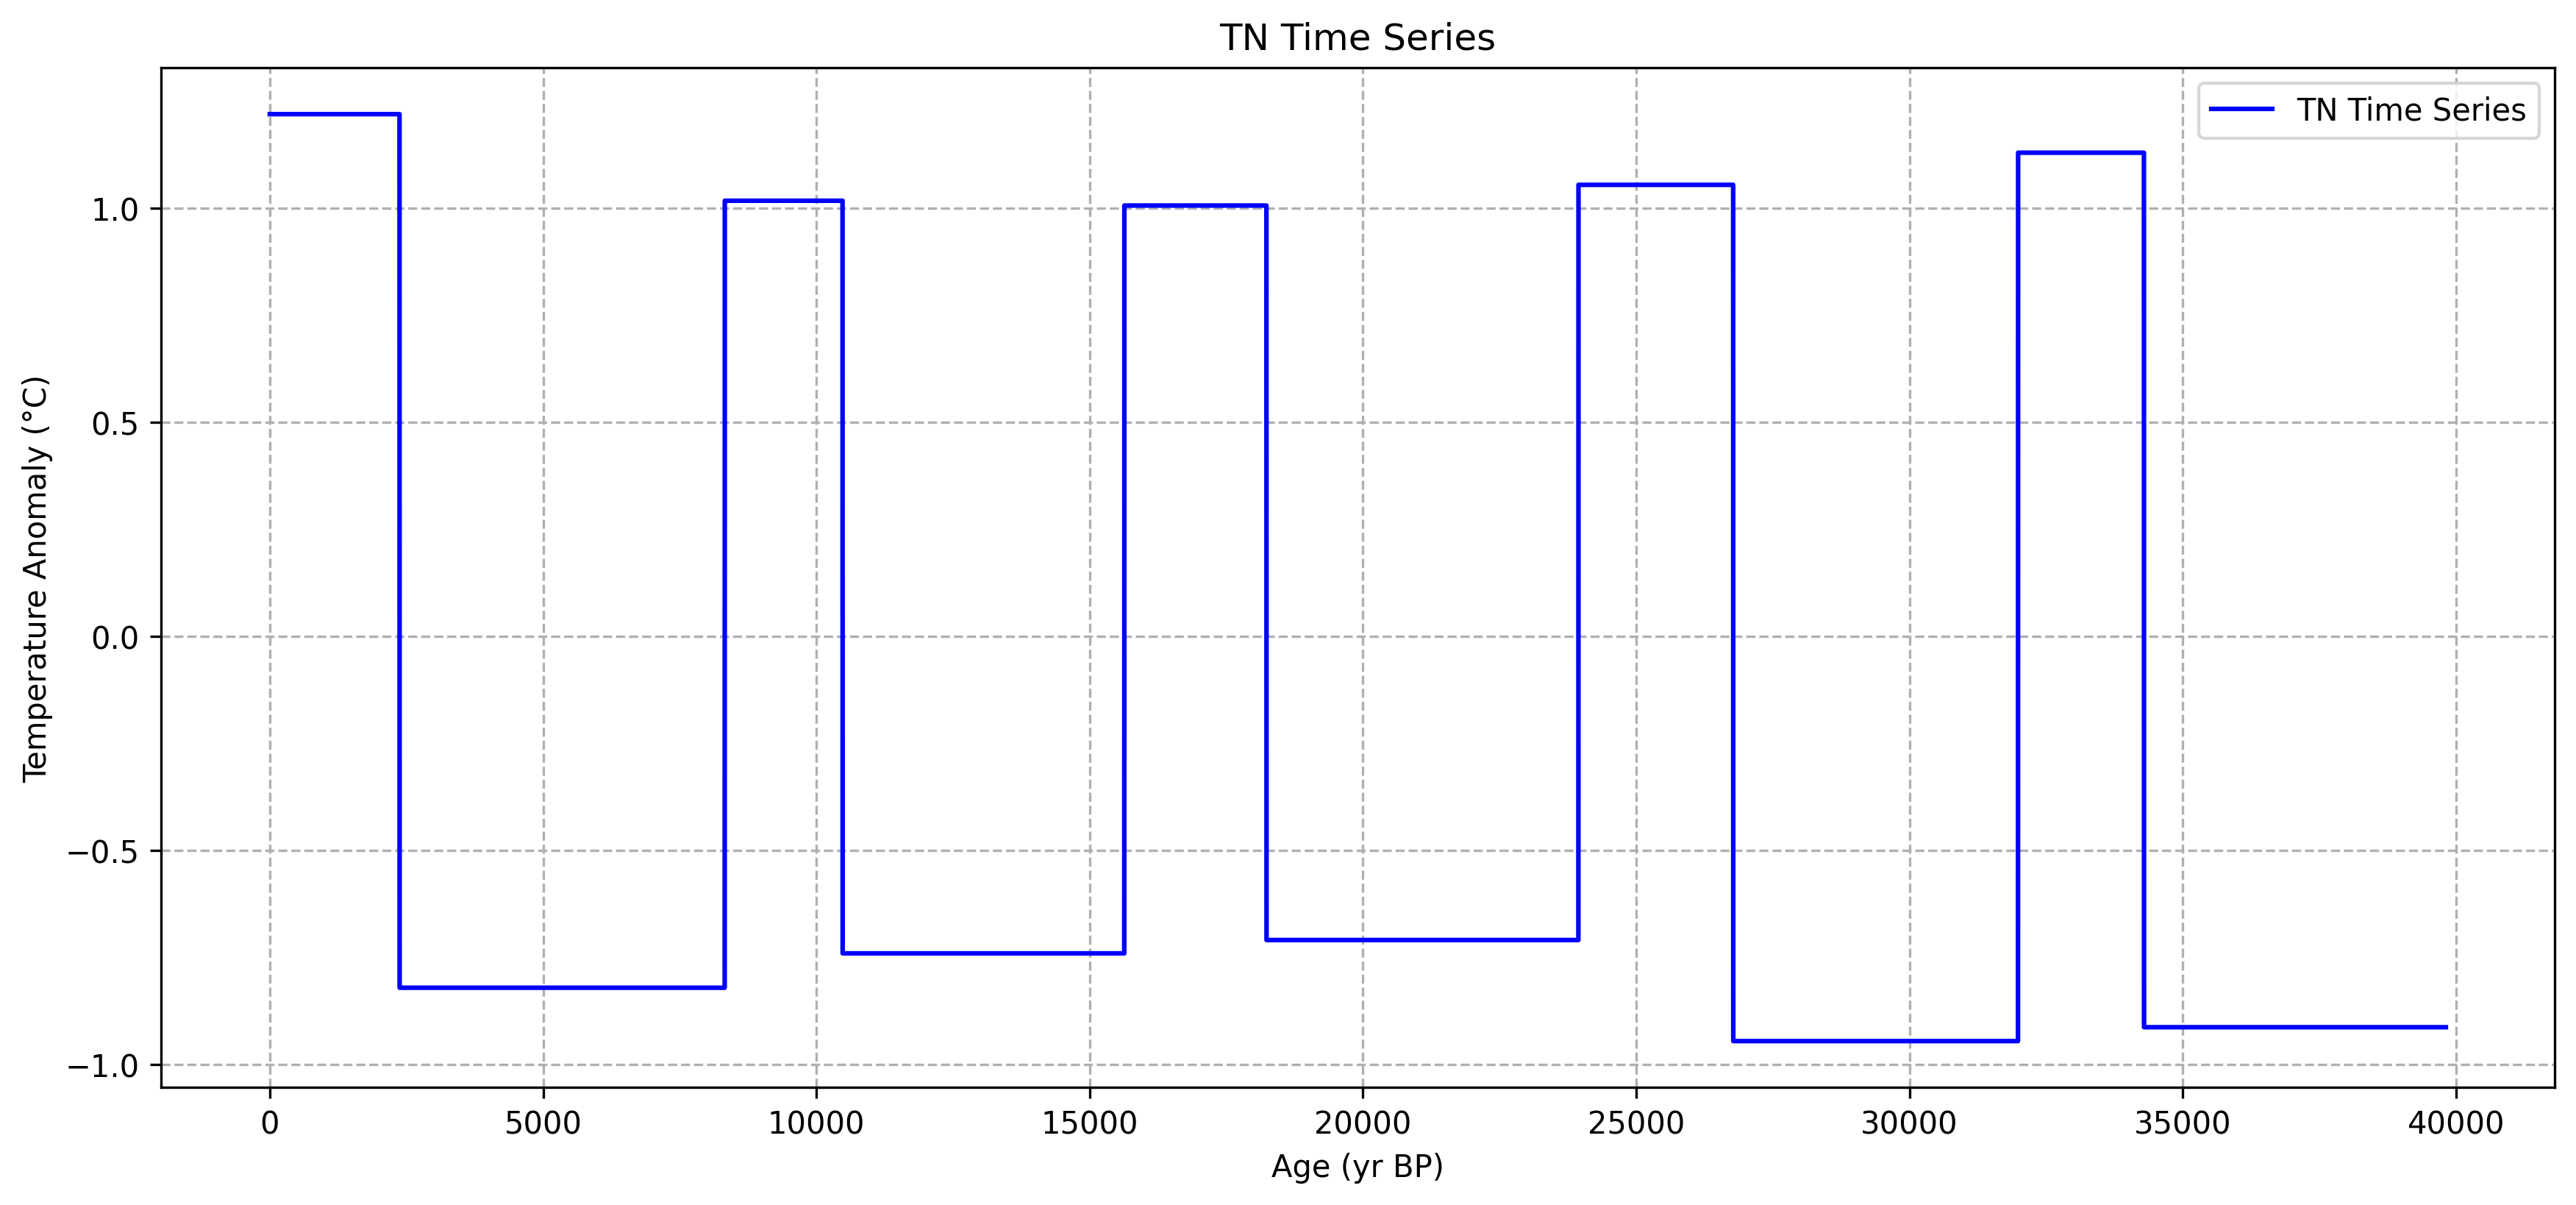

In [41]:
import matplotlib.pyplot as plt

# Plot the generated TN time series without using a function
plt.figure(figsize=(14, 6),dpi=300)
plt.plot(tn_time_series, label='TN Time Series', color='b')
plt.xlabel('Age (yr BP)')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('TN Time Series')
# add grid with linestyle '--'
plt.grid(linestyle='--')
plt.legend()
plt.show()


# The model

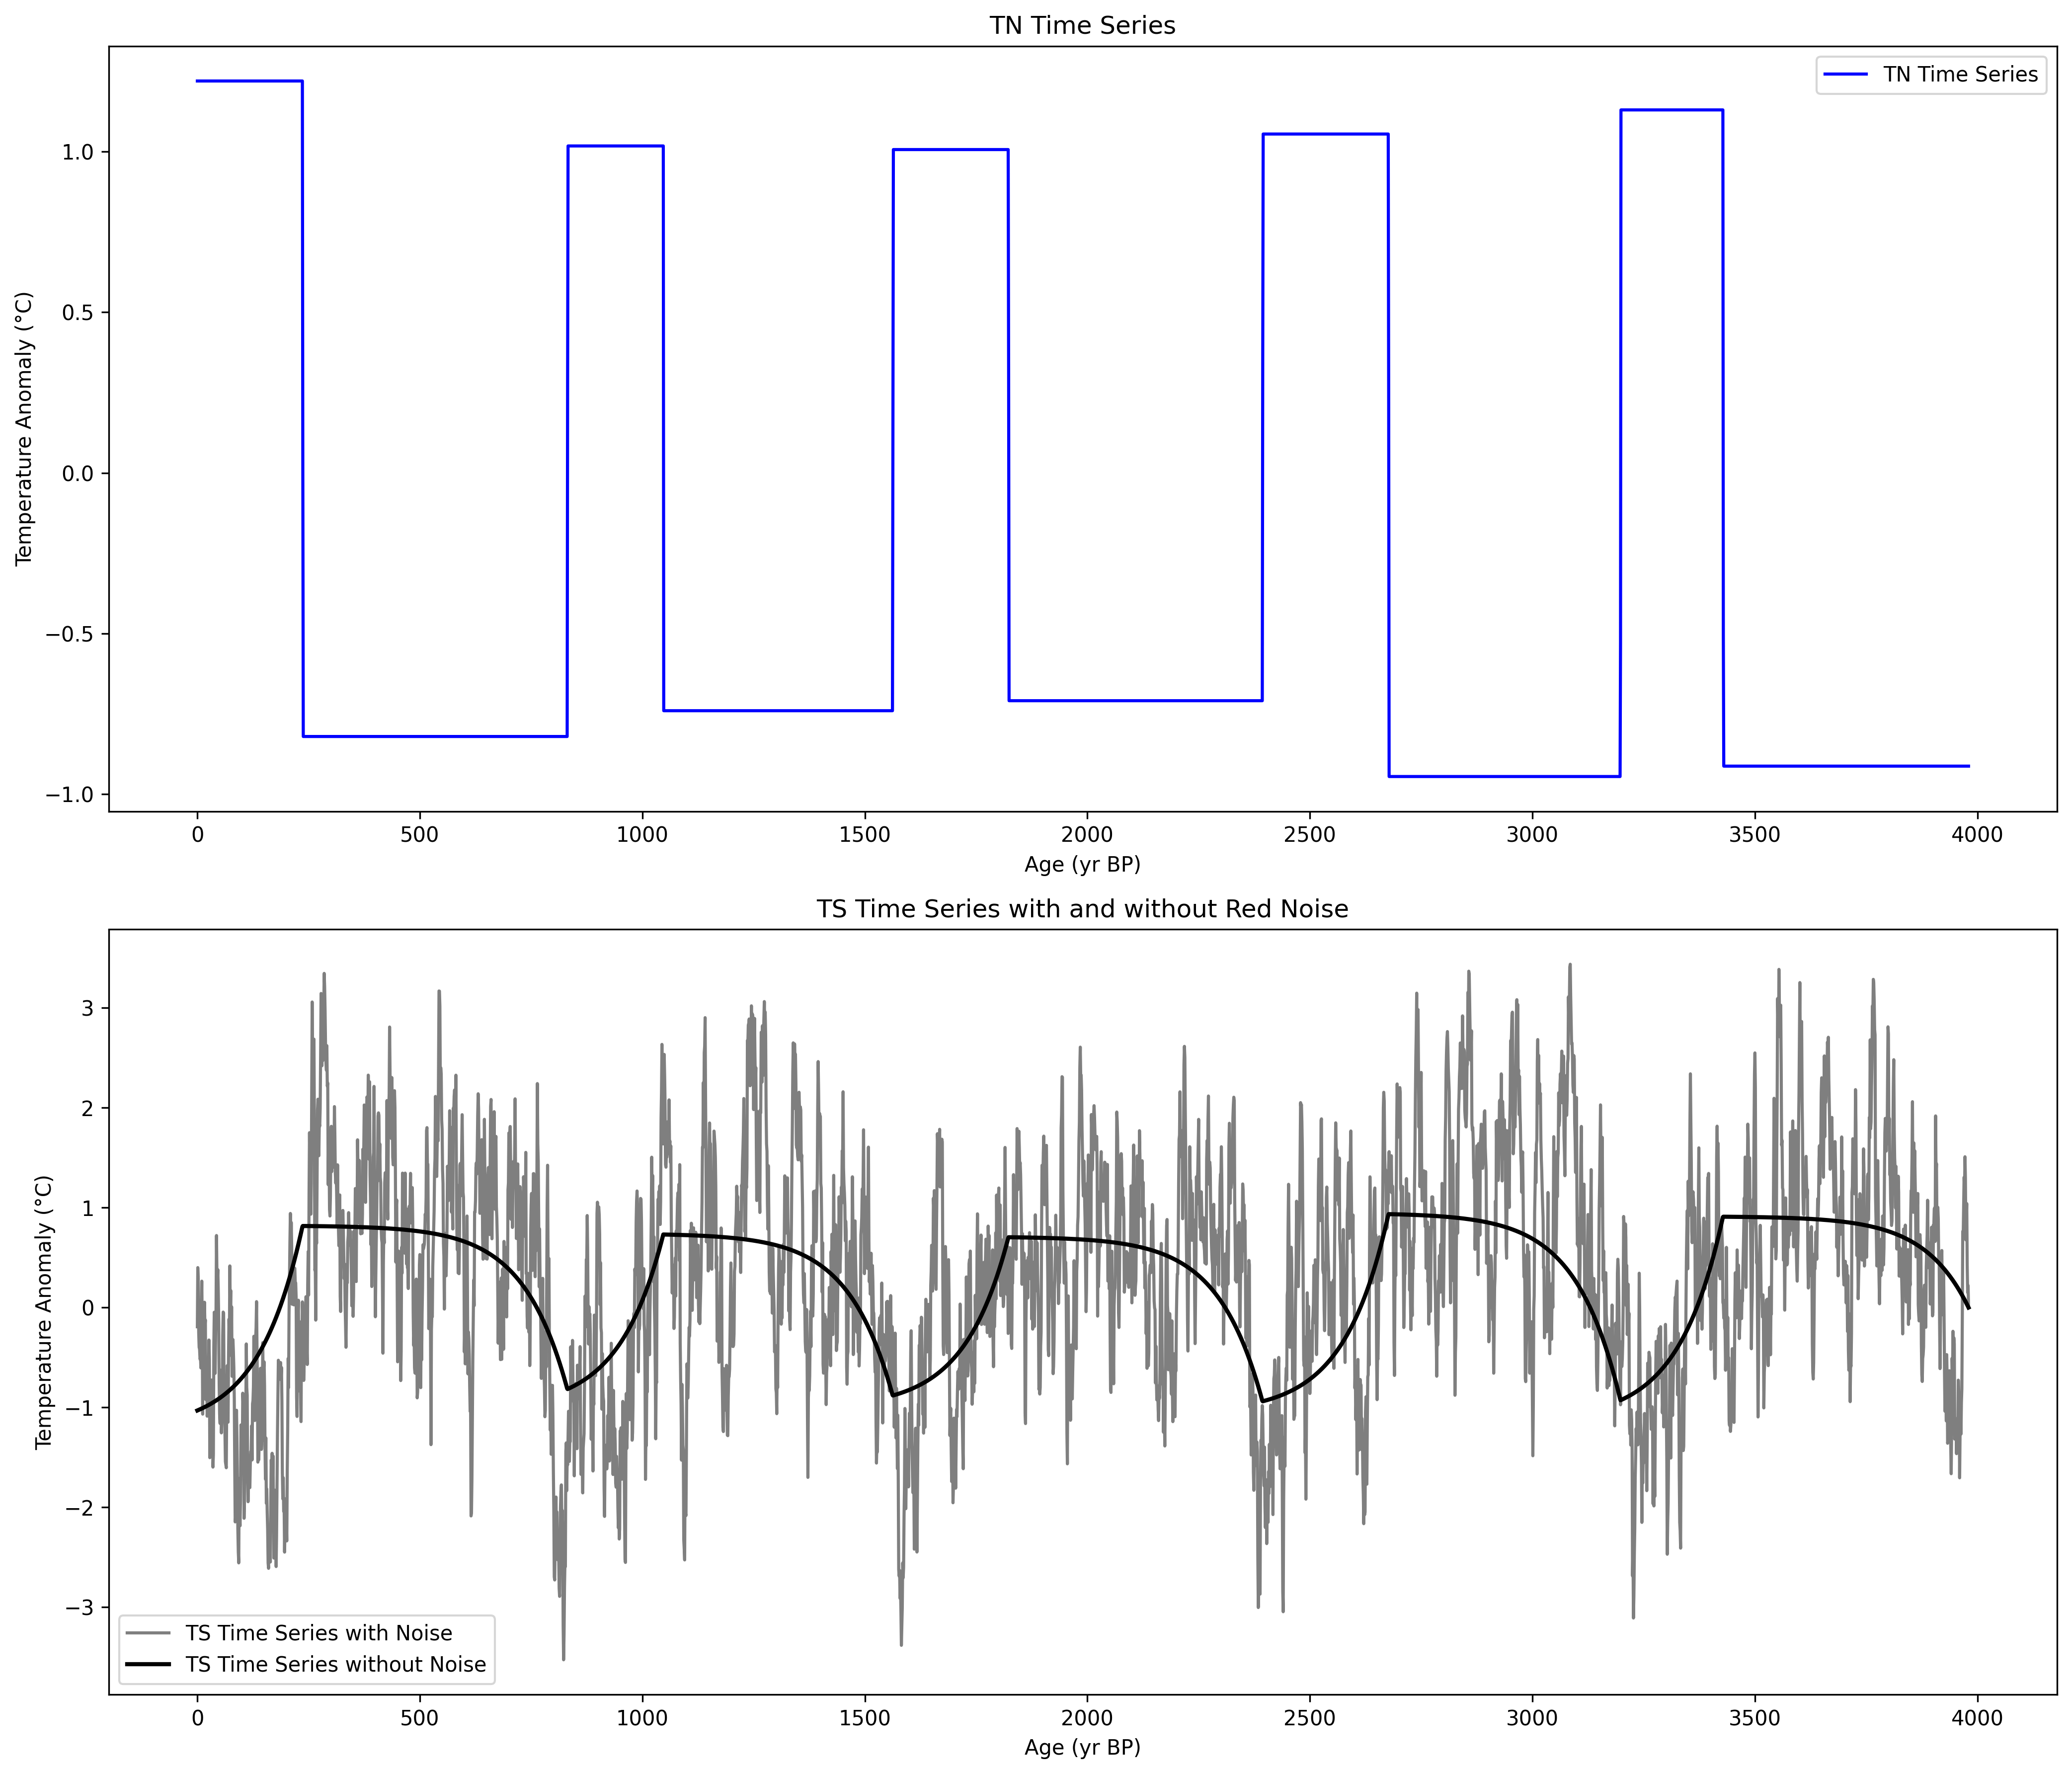

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Resample TN time series to match timestep dt of 10 years
def resample_TN(tn_series, dt=10):
    # Calculate the number of periods in the resampled series
    num_periods = len(tn_series) // dt
    # Resample by averaging over each dt period
    resampled_tn = np.array([np.mean(tn_series[i*dt:(i+1)*dt]) for i in range(num_periods)])
    return resampled_tn

# Parameters for the model
dt = 10  # Time step in years
tau = 1000  # Characteristic timescale in years
TS_initial = 0  # Initial condition for TS
a = 0.9  # Red noise parameter
std_dev = 0.1  # Standard deviation for the white noise component

# Generate and resample a shorter TN time series
tn_time_series_shortened = generate_TN_time_series(duration=40000)
tn_time_series_resampled = resample_TN(tn_time_series_shortened, dt)

# Calculate TS without noise, reversing the calculation direction
TS_without_noise_reversed = np.zeros(len(tn_time_series_resampled))
TS_without_noise_reversed[-1] = TS_initial
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise_reversed[i+1])
    TS_without_noise_reversed[i] = TS_without_noise_reversed[i+1] + delta_TS

# Adjust the standard deviation for red noise based on the variance of TS without noise
variance_TS_without_noise = np.var(TS_without_noise_reversed)
adjusted_std_dev = np.sqrt(variance_TS_without_noise / 2)

np.random.seed(42)
# Generate adjusted red noise
red_noise_reversed = np.zeros(len(tn_time_series_resampled))
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    epsilon_t = np.random.normal(0, adjusted_std_dev)
    red_noise_reversed[i] = a * red_noise_reversed[i+1] + epsilon_t

# Add adjusted red noise to TS without noise
TS_with_adjusted_noise_reversed = TS_without_noise_reversed + red_noise_reversed

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 12),dpi=300)
axs[0].plot(tn_time_series_resampled, label='TN Time Series', color='blue')
axs[0].set_title('TN Time Series')
axs[0].set_xlabel('Age (yr BP)')
axs[0].set_ylabel('Temperature Anomaly (°C)')
axs[0].legend()

axs[1].plot(TS_with_adjusted_noise_reversed, label='TS Time Series with Noise', color='k', alpha=0.5,linestyle='-')
axs[1].plot(TS_without_noise_reversed, label='TS Time Series without Noise', color='k', linewidth=2, linestyle='-')
axs[1].set_title('TS Time Series with and without Red Noise')
axs[1].set_xlabel('Age (yr BP)')
axs[1].set_ylabel('Temperature Anomaly (°C)')
axs[1].legend()

plt.tight_layout()
plt.show()


# correlation plot

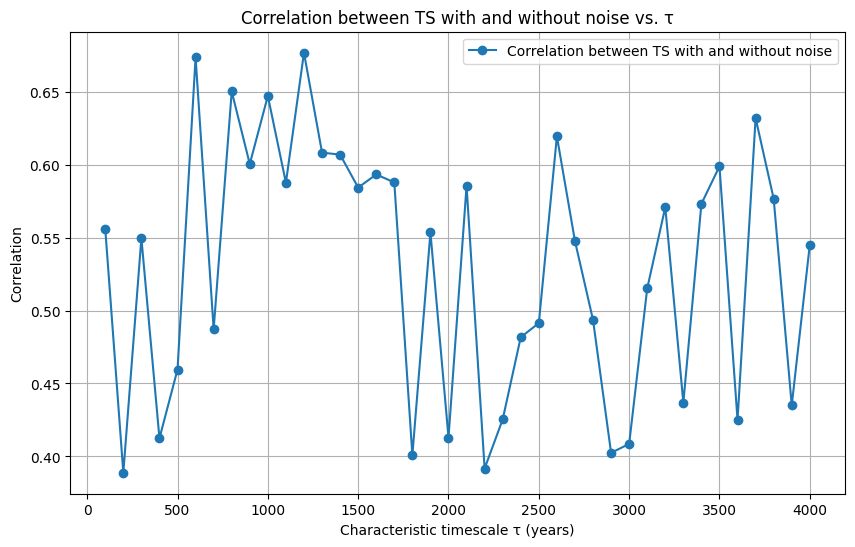

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Given parameters
duration = 9000  # Duration for TS generation
on_time, off_time = 2000, 5000  # On and off times for TN generation
on_amp, off_amp = 1, -1  # On and off amplitudes for TN generation
a = 0.9  # Red noise parameter
std_dev_initial = 0.1  # Initial standard deviation for white noise component, adjusted later
dt = 10  # Time step in years
TS_initial = 0  # Initial condition for TS

# Assuming generate_TN_time_series and resample_TN are defined based on the provided snippets

# Generate and resample TN time series
tn_time_series_shortened = generate_TN_time_series(duration=duration, on_time=on_time, off_time=off_time)
tn_time_series_resampled = resample_TN(tn_time_series_shortened, dt=dt)

# Range of tau values to test
tau_values = np.arange(100, 4001, 100)

# List to store correlation values
correlations = []

# Correcting the generation of red noise according to the user's instruction
np.random.seed(42)  # Ensuring reproducibility

for tau in tau_values:
    TS_without_noise = np.zeros(len(tn_time_series_resampled))
    TS_without_noise[-1] = TS_initial  # Setting initial condition at the last index for reverse calculation
    for i in range(len(tn_time_series_resampled) - 2, -1, -1):
        delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise[i+1])
        TS_without_noise[i] = TS_without_noise[i+1] + delta_TS

    # Adjusting red noise generation
    variance_TS_without_noise = np.var(TS_without_noise)
    adjusted_std_dev = np.sqrt(variance_TS_without_noise / 2)
    
    red_noise = np.zeros(len(TS_without_noise))
    red_noise[0] = np.random.normal(0, adjusted_std_dev)  # Initial red noise
    for i in range(1, len(TS_without_noise)):
        red_noise[i] = a * red_noise[i-1] + np.random.normal(0, adjusted_std_dev)

    TS_with_noise = TS_without_noise + red_noise

    # Calculating correlation
    correlation, _ = pearsonr(TS_without_noise, TS_with_noise)
    correlations.append(correlation)

# Plotting correlation vs. tau
plt.figure(figsize=(10, 6))
plt.plot(tau_values, correlations, label='Correlation between TS with and without noise', marker='o')
plt.xlabel('Characteristic timescale τ (years)')
plt.ylabel('Correlation')
plt.title('Correlation between TS with and without noise vs. τ')
plt.grid(True)
plt.legend()
plt.show()


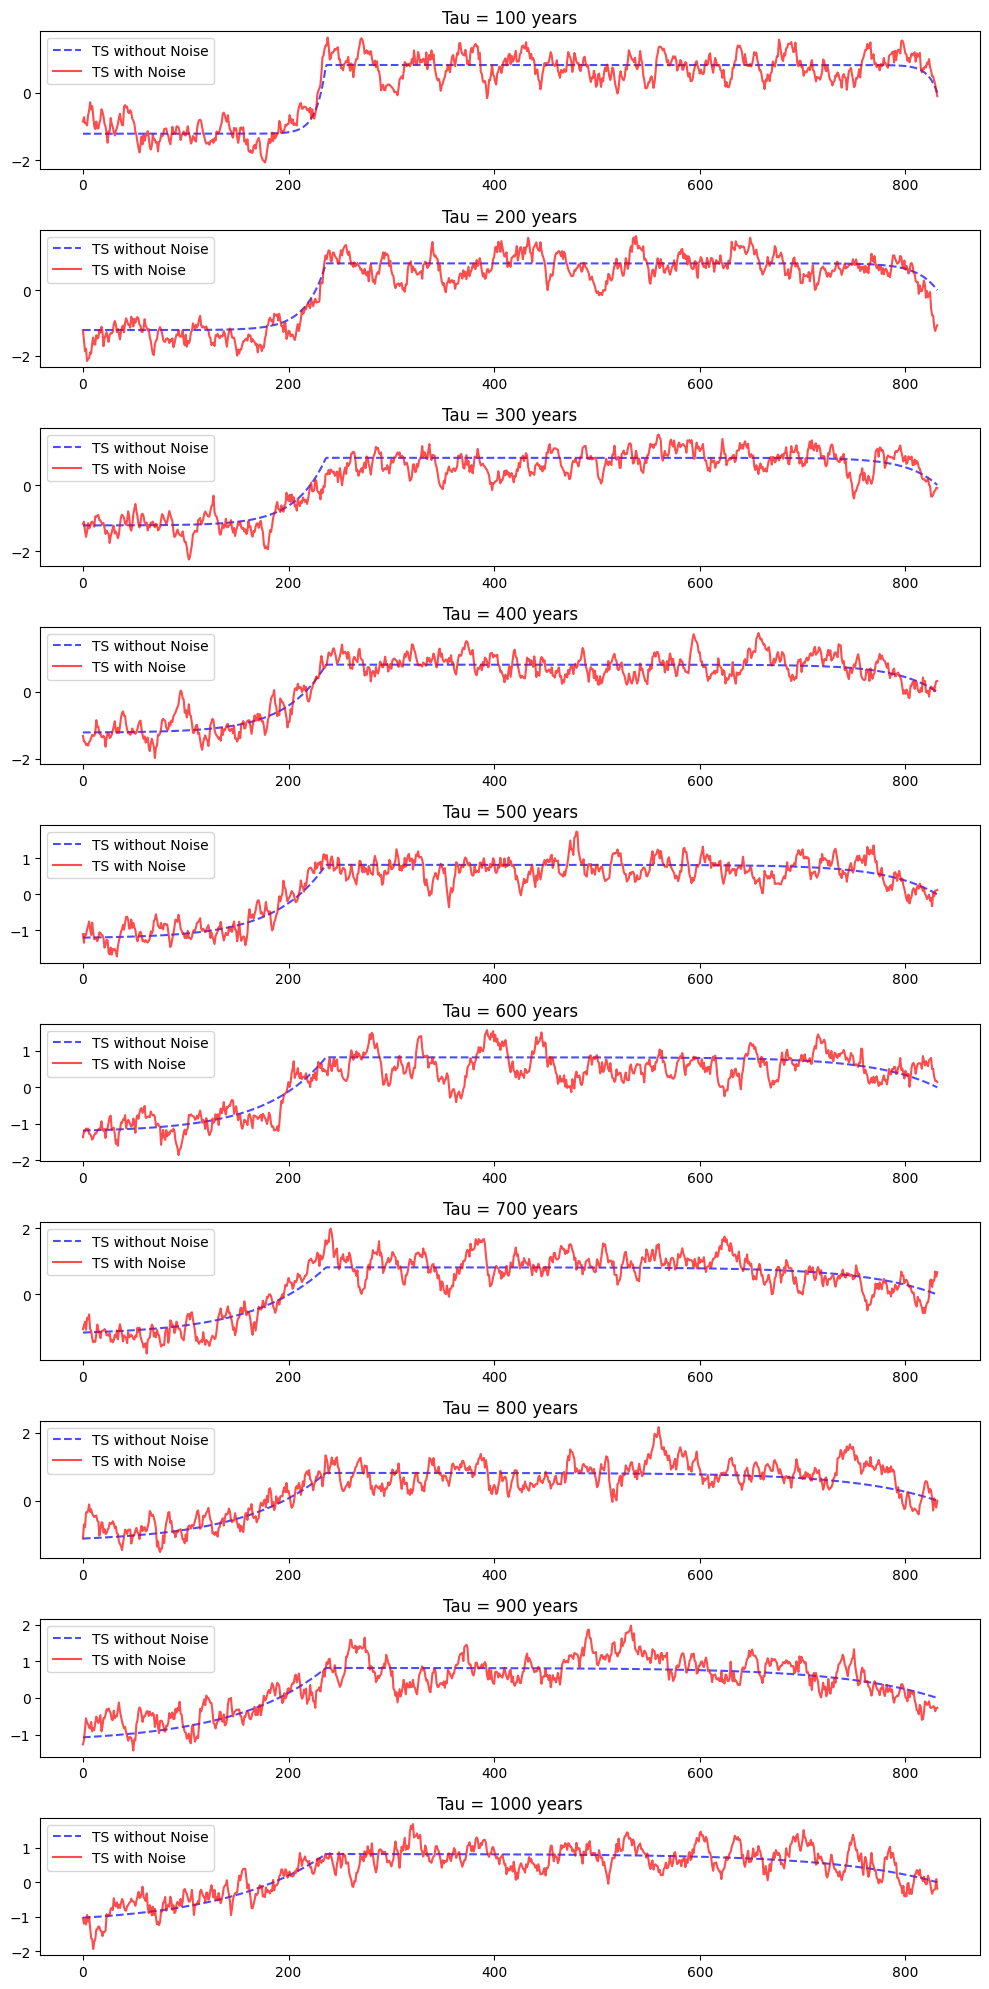

In [87]:
fig, axs = plt.subplots(10, 1, figsize=(10, 20), dpi=100)

# Loop through the first 10 tau values and plot TS with and without noise
for index, tau in enumerate(tau_values[:10]):
    # Generate TS without noise
    TS_without_noise = np.zeros(len(tn_time_series_resampled))
    TS_without_noise[-1] = TS_initial  # Start from the end for reverse calculation
    for i in range(len(tn_time_series_resampled) - 2, -1, -1):
        delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise[i+1])
        TS_without_noise[i] = TS_without_noise[i+1] + delta_TS

    # Generate red noise and TS with noise
    red_noise = np.zeros(len(TS_without_noise))
    red_noise[0] = np.random.normal(0, adjusted_std_dev)  # Initial red noise
    for i in range(1, len(TS_without_noise)):
        red_noise[i] = a * red_noise[i-1] + np.random.normal(0, adjusted_std_dev)
    TS_with_noise = TS_without_noise + red_noise

    # Plot TS without and with noise for this tau value
    axs[index].plot(TS_without_noise, label='TS without Noise', color='blue', alpha=0.7, linestyle='--')
    axs[index].plot(TS_with_noise, label='TS with Noise', color='red', alpha=0.7, linestyle='-')
    axs[index].set_title(f'Tau = {tau} years')
    axs[index].legend()

plt.tight_layout()
plt.show()

What are intermittent “jumps” in the TN time series meant to represent? 
    warming/AMOC resume

What do the various model parameters (i.e., TN, TS, τ, t) in SJ03 Equation 2 represent?  What happens when you change τ in your model, and what does this change represent conceptually? 

- **TS**: Represents the temperature anomaly of the southern end of the bipolar seesaw, or the heat reservoir. This is a measure of the deviation in temperature from some reference value, indicating how much warmer or cooler the southern end is compared to this reference.

- **TN**: Denotes the time-dependent temperature anomaly of the northern end of the bipolar seesaw. Similar to TS, it represents the deviation in temperature from a reference value, but for the northern end. TN is a function of time, reflecting how the temperature anomaly changes over time due to various climate processes.

- **τ (tau)**: The characteristic timescale of the heat reservoir, which is a measure of the response time of the southern heat reservoir (or the southern end of the seesaw) to changes in temperature. It reflects how quickly or slowly the temperature anomaly at the southern end responds to changes, with larger values indicating a slower response and smaller values indicating a quicker response.

- **t**: Represents time in the context of the integral within Equation 2. It is used to calculate the convolution of the northern temperature anomaly (TN) over time, adjusted by the exponential decay factor \(e^{-t0/\tau}\) where \(t0\) is a variable of integration. This convolution integrates the effect of past temperature anomalies in the north over the characteristic timescale τ, effectively modeling the "memory" of the heat reservoir.


What utility does the “red noise” addition provide to the SJ03 model, and how should one interpret this noise physically?  How could you make Eq. 4 more or less “red”?
- If the temperature of the heat reservoir TS is not influenced by other processes, we obtain identical time series. However, in reality, these temperatures are strongly influenced by local climate variability. We account for this by adding a red noise signal to TS

Briefly discuss how the SJ03 model is being applied in Figure 4.  Are you impressed by the comparisons to the Byrd ice core isotopic data?  Why or why not?


SJ03 define their model as the “simplest possible thermodynamic model” one can make of the bipolar see-saw.  What climate process(es) does this simple model help us explain?  What crucial process(es) are missing from this model?  
- meridional energy redistribution
- Orbital forcing; Changes in the CO2; processes in tropics


In [27]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntSlider

# Parameters
duration =5000
dt = 10
TS_initial = 0
a = 0.9

# Assuming a function to generate TN time series
def generate_test_TN_time_series(duration=40000):
    return np.ones(duration // dt) * -1  # Example TN series

def plot_TS(tau, std_factor):
    
    tn_time_series = generate_test_TN_time_series(duration)
    TS_without_noise = np.zeros_like(tn_time_series)
    TS_without_noise[-1] = TS_initial
    
    for i in range(len(tn_time_series) - 2, -1, -1):
        delta_TS = dt * (1/tau) * (-tn_time_series[i+1] - TS_without_noise[i+1])
        TS_without_noise[i] = TS_without_noise[i+1] + delta_TS

    variance_TS_without_noise = np.var(TS_without_noise)
    adjusted_std_dev = np.sqrt(variance_TS_without_noise) * std_factor

    np.random.seed(42)
    red_noise = np.zeros_like(tn_time_series)
    for i in range(1, len(tn_time_series)):
        red_noise[i] = a * red_noise[i-1] + np.random.normal(0, adjusted_std_dev)

    TS_with_noise = TS_without_noise + red_noise

    plt.clf()
    plt.plot(TS_without_noise, label='TS without Noise', linestyle='--')
    plt.plot(TS_with_noise, label='TS with Noise')
    plt.xlabel('Age (yr BP)')
    plt.ylabel('Temperature Anomaly (°C)')
    plt.legend()
    plt.show()

interactive_plot = interactive(plot_TS, tau=IntSlider(min=100, max=4000, step=100, value=1000, description='Tau', continuous_update=False),
                               std_factor=FloatSlider(min=0, max=4, step=0.1, value=0.5, description='Std Dev Factor', continuous_update=False))

display(interactive_plot)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Tau', max=4000, min=100, ste…